In [1]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import random
import math

In [52]:
def save_img(path, img):
    cv2.imwrite(path, img)
    print(path, "is saved!")

def display_img(img):
    cv2.imshow('Result', img)
    cv2.waitKey()

def read_img(path):
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    # if need double type, uncomment the following
    out = image.astype(float)
    return image

def read_colorimg(path):
    image = cv2.imread(path)
    # if need double type, uncomment the following
    # out = image.astype(float)
    return image

In [53]:
def homography_transform(X, H):
    # Perform homography transformation on a set of points X
    # using homography matrix H
    # Input - a set of 2D points in an array with size (N,2)
    #         a 3*3 homography matrix 
    # Output - a set of 2D points in an array with size (N,2)
    M, N = X.shape
    A = np.hstack((X, np.ones((M, 1))))  # A: M x 3
    Y = A @ H
    return Y

def fit_homography(XY):
    # Given two set of points X, Y in one array,
    # fit a homography matrix from X to Y
    # Input - an array with size(N,4), each row contains two
    #         points in the form[x^T_i,y^T_i]1×4
    # Output - a 3*3 homography matrix
    X, Y = XY[:, :2], XY[:, 2:]  # y points
    M, N = XY.shape
    
    # build matrix A based on the correspondences
    A = []
    for i in range(M):
        x1, x2 = X[i, 0], X[i, 1]
        y1, y2 = Y[i, 0], Y[i, 1]
        
        # equation for each correspondence
        A.append([-x1, -x2, -1, 0, 0, 0, y1 * x1, y1 * x2, y1])
        A.append([0, 0, 0, -x1, -x2, -1, y2 * x1, y2 * x2, y2])
        
    A = np.array(A)
    
    # solve Ah = 0 using SVD
    U, S, V = np.linalg.svd(A)
    
    # solution h is the smallest singular value of V
    h = V[-1, :]
    
    # build H matrix & normalization
    H = h.reshape(3, 3)
    H = H / H[2, 2]
    
    return H

In [55]:
def p1():
    # 1.2.3 - 1.2.5
    # 1. load points X from p1/transform.npy
    data = np.load("p1/transform.npy")
    X = data[:, :2]  # x points
    Y = data[:, 2:]  # y points
    print(f"X:{X.shape}")
    print(f"Y:{Y.shape}\n")
    
    # 2. fit a transformation y=Sx+t
    M, N = data.shape
    A = np.hstack((X, np.ones((M, 1))))  # A: M x 3
    b = Y                                # b: M x 2
    print(f"A:{A.shape}")
    print(f"b:{b.shape}")
    
    v = np.linalg.lstsq(A, b, rcond=None)[0]
    S = v[:2]  # S: 2 x 2
    t = v[2:]  # t: 2 x 1
    print(f"S:\n{S}")
    print(f"t:\n{t}\n")

    # 3. transform the points
    Y_hat = X @ S.T + t
    print(f"Y_hat:{Y_hat.shape}")

    # 4. plot the original points and transformed points
    plt.figure(figsize=(10, 6))
    plt.scatter(X[:, 0], X[:, 1], color='blue', label='Input points (X)', marker='o')
    plt.scatter(Y[:, 0], Y[:, 1], color='red', label='Target points (Y)', marker='x')
    plt.scatter(Y_hat[:, 0], Y_hat[:, 1], color='green', label='Predicted points (ŷ)', marker='^')

    plt.title('Input, Target, and Predicted Points')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # 5.
    """
    Q: Explain how you transform the points in words based on S and t.
    Is the fitting result good?
    
    A: Matrix S represents how the input points (x) are transformed through 
    scaling and rotation (linear transformation). Each input point is multiplied
    by matrix S, changing its size and direction. Vector t represents how the
    linearly transformed input points are positionally shifted (translation).
    
    For this particular fitting result, we see that while the scale or variance,
    and perhaps the translation too, of the predicted distribution is quite good,
    the rotation is significantly off.
    """

    # 1.2.6 - 1.2.8
    case = 8 # you will encounter 8 different transformations
    for i in range(case):
        XY = np.load('p1/points_case_'+str(i)+'.npy')
        # 1. generate your Homography matrix H using X and Y
        H = fit_homography(XY)
        
        # 2. Report H in your report
        print(f"\nCase #{i} H:\n{H}")
        
        # 3. Transform the points using H
        Y_H = homography_transform(XY[:,:2], H)
        
        # 4. Visualize points as three images in one figure
        # the following codes plot figure for you
        plt.scatter(XY[:,1],XY[:,0],c="red") #X
        plt.scatter(XY[:,3],XY[:,2],c="green") #Y
        plt.scatter(Y_H[:,1],Y_H[:,0],c="blue") #Y_hat
        plt.savefig('./p1_cases/case_'+str(i))
        plt.close()
    
    """
    Q: Discuss the transformations your observed in visualization with 
    the homography matrix H. Do they make sense to you?
    
    A: All of the homographic transformations seem to make sense except for
    one, case #4. These transformations are designed to map one set of points
    in a 2D plane to another set of points in a different plane. The H matrix
    captures the relationship between two views of the same planar surface
    under different camera perspectives. In all of the cases except #4, we see
    the transformed X-points approximating their respective Y-points. In #4, the
    predicted points match the flipped Y-image orientation, but appear diagonal
    positionally to the Y-image.
    """


In [156]:
def normalize(M):
    return (M - M.mean()) / M.std()

def match_descriptors(distances, threshold):
    matches = np.argwhere(distances < threshold)
    print(f"Descriptor matches (d<{threshold}): {matches.shape}")
    return matches

def sift_image(img, savename):
    # initialize SIFT detector
    sift = cv2.SIFT_create()
    sift.setContrastThreshold(0.15)
    sift.setEdgeThreshold(7)
    
    # detect key points and compute descriptors
    keypoints, descriptors = sift.detectAndCompute(img, None)

    # draw & save image
    kp_img = cv2.drawKeypoints(
        img,
        keypoints,
        None,
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )
    save_img('./p2_output/sift_' + savename + '.jpg', kp_img)
    
    # return vars
    return keypoints, descriptors

def descriptor_distances(descriptors1, descriptors2):
    # normalize descriptors
    descriptors1 = normalize(descriptors1)
    descriptors2 = normalize(descriptors2)

    # init distance matrix
    distances = np.zeros((descriptors1.shape[0], descriptors2.shape[0]))
    print(f"Descriptor distance matrix: {distances.shape}, {distances.size}")
    
    # calculate distances
    for i, d1 in enumerate(descriptors1):
        for j, d2 in enumerate(descriptors2):
            # euclidean distance
            distances[i, j] = np.sqrt(np.sum((d1 - d2) ** 2))
    
    # return distance matrix
    return distances

def stitchimage(imgleft, imgright):
    # TODO
    # 1. extract descriptors from images
    #    you may use SIFT/SURF of opencv

    # 2. select paired descriptors

    # 3. run RANSAC to find a transformation
    #    matrix which has most innerliers

    # 4. warp one image by your transformation 
    #    matrix
    #
    #    Hint: 
    #    a. you can use opencv to warp image
    #    b. Be careful about final image size

    # 5. combine two images, use average of them
    #    in the overlap area

    pass

def ransac(X, Y, p=4, n_iters=10000):
    m, _ = X.shape
    data = np.column_stack((X, Y))
    
    eps = np.std(Y / 2)  # threshold
    best_ninliers = 0
    best_model = None
    best_residual = 0.0
    best_inliers = None
    best_dmatches = None

    for i in range(n_iters):
        # shuffle & select p-samples
        np.random.shuffle(data)
        samples = data[:p, :]
        s_X, s_Y = samples[:, :2], samples[:, 2:]

        # fit model
        H = fit_homography(samples)

        # count inliers
        Y_hat = homography_transform(X, H)[:,:2]
        err = np.sqrt(np.sum((Y - Y_hat) ** 2, axis=1))
        inlier_mask = err < eps
        n_inliers = np.count_nonzero(inlier_mask)

        # find best model
        if n_inliers > best_ninliers:
            best_ninliers = n_inliers
            best_model = H
            best_residual = err.mean()
            best_inliers = data[inlier_mask]
            best_dmatches = [cv2.DMatch(_distance=err[i], _queryIdx=i, _trainIdx=i) for i, t in enumerate(inlier_mask) if t]

        # report results
        p_outlier = 1 - (n_inliers / m)
        # print(f"{i}: n_inliers={n_inliers}, p_outlier={p_outlier}")

    # return best model inlier mask
    print(f"# Best Model: n_inliers={best_ninliers}, avg_residual={best_residual}, H=\n{best_model}")
    return best_dmatches

In [161]:
def p2(p1, p2, savename):
    """
    Q1: read grayscale images.
    """
    img1_grey = read_img(p1)
    img2_grey = read_img(p2)
    save_img('./p2_output/grey_' + f"{savename}1" + '.jpg', img1_grey)
    save_img('./p2_output/grey_' + f"{savename}2" + '.jpg', img2_grey)
    
    """
    Q2: detect feature points.
    """
    img1_keypoints, img1_descriptors = sift_image(img1_grey, f"{savename}1")
    img2_keypoints, img2_descriptors = sift_image(img2_grey, f"{savename}2")

    """
    Q3: calculate pair-wise descriptor distances.
    """
    distances = descriptor_distances(img1_descriptors, img2_descriptors)

    """
    Q4: select keypoint putative matches based on descriptor distances.
    """
    descriptor_matches = match_descriptors(distances, threshold=7.0)
    img1_keypoints = np.array(img1_keypoints)[descriptor_matches[:, 0]]
    img2_keypoints = np.array(img2_keypoints)[descriptor_matches[:, 1]]

    """
    Q5: RANSAC.
    """
    X = np.array([kp.pt for kp in img1_keypoints])
    Y = np.array([kp.pt for kp in img2_keypoints])
    inlier_matches = ransac(X, Y)
    inlier_img = cv2.drawMatches(
        img1_grey,
        img1_keypoints,
        img2_grey,
        img2_keypoints,
        inlier_matches,
        outImg=None,
        matchesThickness=1,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    save_img('./p2_output/inliers_' + savename + '.jpg', inlier_img)
    
    # stitch image
    # output = stitchimage(imgleft, imgright)
    
    # save stitched image
    # save_img('./p2_output/' + savename + '.jpg', output)

In [162]:
# Problem 2
p2('p2/uttower_left.jpg', 'p2/uttower_right.jpg', 'uttower')
# p2('p2/bbb_left.jpg', 'p2/bbb_right.jpg', 'bbb')

./p2_output/grey_uttower1.jpg is saved!
./p2_output/grey_uttower2.jpg is saved!
./p2_output/sift_uttower1.jpg is saved!
./p2_output/sift_uttower2.jpg is saved!
Descriptor distance matrix: (491, 444), 218004
Descriptor matches (d<7.0): (309, 2)
# Best Model: n_inliers=108, avg_residual=292.415642022045, H=
[[ 3.59128712e-01  1.11407332e+00 -7.86146610e+02]
 [-9.53768651e-02 -1.31558809e-01  3.24255948e+02]
 [-2.03762220e-04 -9.03625691e-04  1.00000000e+00]]
./p2_output/inliers_uttower.jpg is saved!


X:(50, 2)
Y:(50, 2)

A:(50, 3)
b:(50, 2)
S:
[[ 2.04098127 -3.0696843 ]
 [-1.01644528  0.94335775]]
t:
[[-1.87154926 -3.05145812]]

Y_hat:(50, 2)


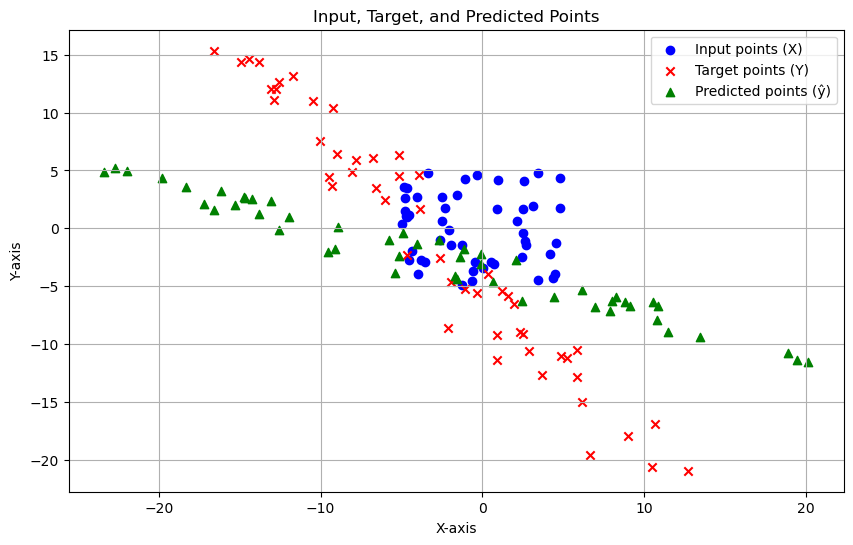


Case #0 H:
[[ 1.00555949e+00  1.61370672e-03 -1.35143989e-01]
 [ 2.56045861e-03  6.22536404e-01 -7.35872070e-01]
 [ 4.51704286e-05  3.59823762e-05  1.00000000e+00]]

Case #1 H:
[[ 6.20394776e-01  1.50050345e-03 -6.60977645e-01]
 [ 4.62565656e-05  1.00232229e+00 -4.06369835e-02]
 [ 3.66035139e-07  2.25931463e-05  1.00000000e+00]]

Case #2 H:
[[ 6.46216419e-01  1.01850154e-02 -1.45233663e+00]
 [ 1.39156925e-02  6.46332905e-01 -1.60285342e+00]
 [ 3.11050183e-04  2.76954685e-04  1.00000000e+00]]

Case #3 H:
[[ 1.31514124e-14  1.00000000e+00  7.04253342e-14]
 [ 1.00000000e+00  2.49225015e-15 -1.16019475e-14]
 [ 1.66312086e-17  2.15210566e-17  1.00000000e+00]]

Case #4 H:
[[-1.00000000e+00 -1.04129451e-13  7.60000000e+01]
 [-1.30163993e-14 -1.00000000e+00  1.01000000e+02]
 [-4.29512255e-15  1.29210750e-15  1.00000000e+00]]

Case #5 H:
[[ 4.01387046e-01  6.36777993e-01 -1.79445757e+00]
 [ 6.40534201e-01  3.96745666e-01 -1.76059696e+00]
 [ 2.21034153e-04  1.39932850e-04  1.00000000e+00]]

Cas

In [6]:
# Problem 1
p1()